
# 5CS037 Final Portfolio Project — Regression

**Student Name:** Sriyog Dhital  
**Student ID:** 2461990  

**Dataset:** vgsales.csv  

This project focuses on a supervised regression task using video game sales data. The objective is to predict global video game sales based on selected game-related attributes using classical machine learning models and a neural network regressor.



## United Nations Sustainable Development Goal (UNSDG)

**Selected UNSDG:** SDG 8 – Decent Work and Economic Growth  

The video game industry contributes significantly to economic activity and employment within the digital entertainment sector. Analysing global sales patterns supports understanding of market performance and economic trends related to digital products.



## 1.1 Dataset Description

The Video Game Sales dataset is sourced from Kaggle and contains historical sales information for video games released across different platforms and regions. The dataset includes attributes such as game name, platform, year of release, genre, publisher, and regional as well as global sales figures.

The target variable, **Global_Sales**, represents the total worldwide sales of a video game and is a continuous numeric value. This makes the dataset suitable for regression analysis using supervised machine learning techniques.

**Source:** Kaggle  
**Dataset Link:** https://www.kaggle.com/datasets/gregorut/videogamesales  



## 1.2 Questions the Dataset Can Answer

1. Which game attributes are most strongly associated with higher global sales?
2. How do global sales vary across different platforms and genres?
3. Can global sales be reliably predicted using available game attributes?



## Target Variable

The target variable for this regression task is **Global_Sales**, which represents the total worldwide sales of a video game. As Global_Sales is a continuous numeric value, the problem is addressed using regression techniques.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [23]:

# Load data
df = pd.read_csv("vgsales.csv")
df.head()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [24]:
df[["Global_Sales", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].skew()

,0
Global_Sales,17.400645
NA_Sales,18.799627
EU_Sales,18.875535
JP_Sales,11.206458
Other_Sales,24.233923


In [3]:

print("Shape:", df.shape)
df.info()


Shape: (16598, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


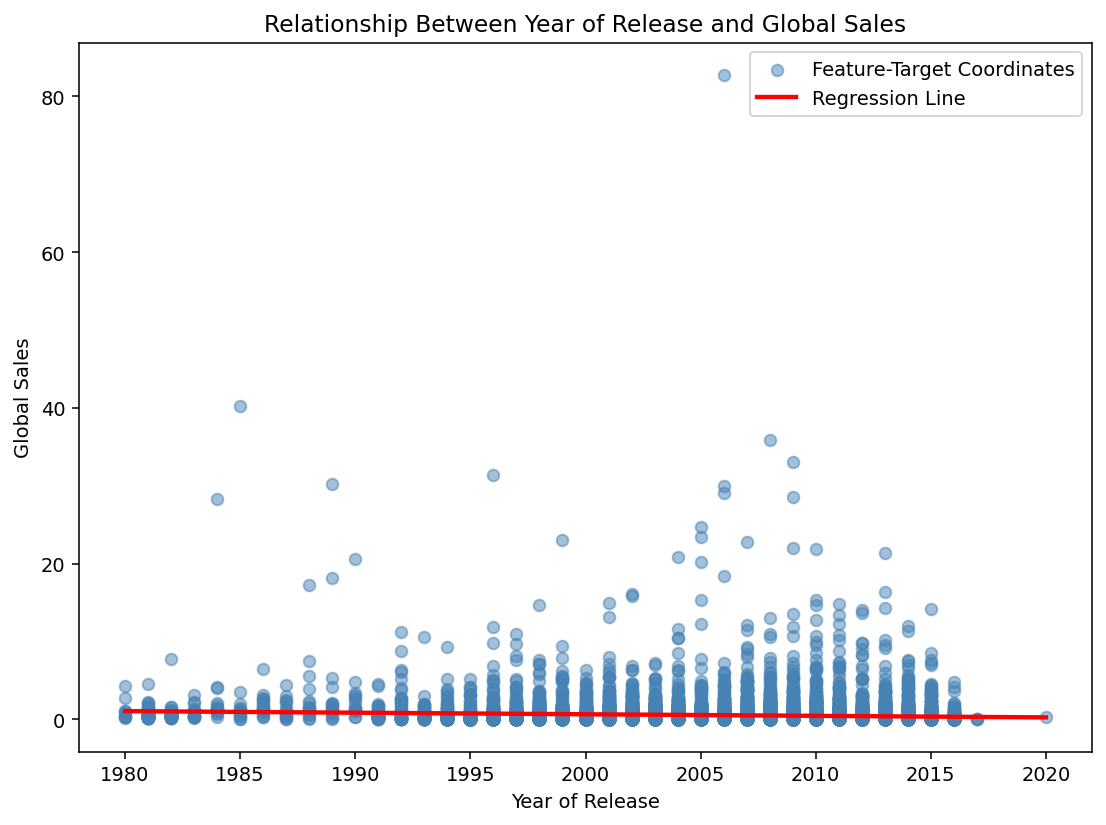

In [21]:
# Relationship plot: Year vs Global Sales (example-style)

plt.figure(figsize=(8,6), dpi=140)

# Scatter points
plt.scatter(
    df["Year"],
    df["Global_Sales"],
    color="steelblue",
    alpha=0.5,
    label="Feature-Target Coordinates"
)

# Regression line
sns.regplot(
    x=df["Year"],
    y=df["Global_Sales"],
    scatter=False,
    color="red",
    label="Regression Line"
)

plt.xlabel("Year of Release")
plt.ylabel("Global Sales")
plt.title("Relationship Between Year of Release and Global Sales")
plt.legend()
plt.tight_layout()
plt.show()


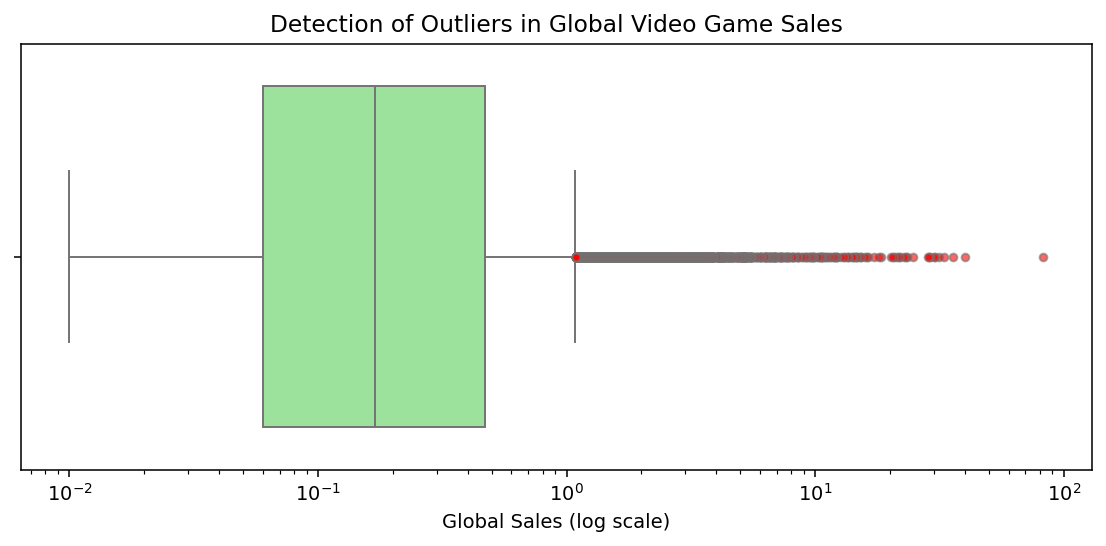

In [5]:
# Box plot with log scale to clearly show outliers

plt.figure(figsize=(8,4), dpi=140)

sns.boxplot(
    x=df["Global_Sales"],
    color="lightgreen",
    flierprops=dict(
        marker='o',
        markerfacecolor='red',
        markersize=4,
        alpha=0.6
    )
)

plt.xscale("log")
plt.xlabel("Global Sales (log scale)")
plt.title("Detection of Outliers in Global Video Game Sales")
plt.tight_layout()
plt.show()


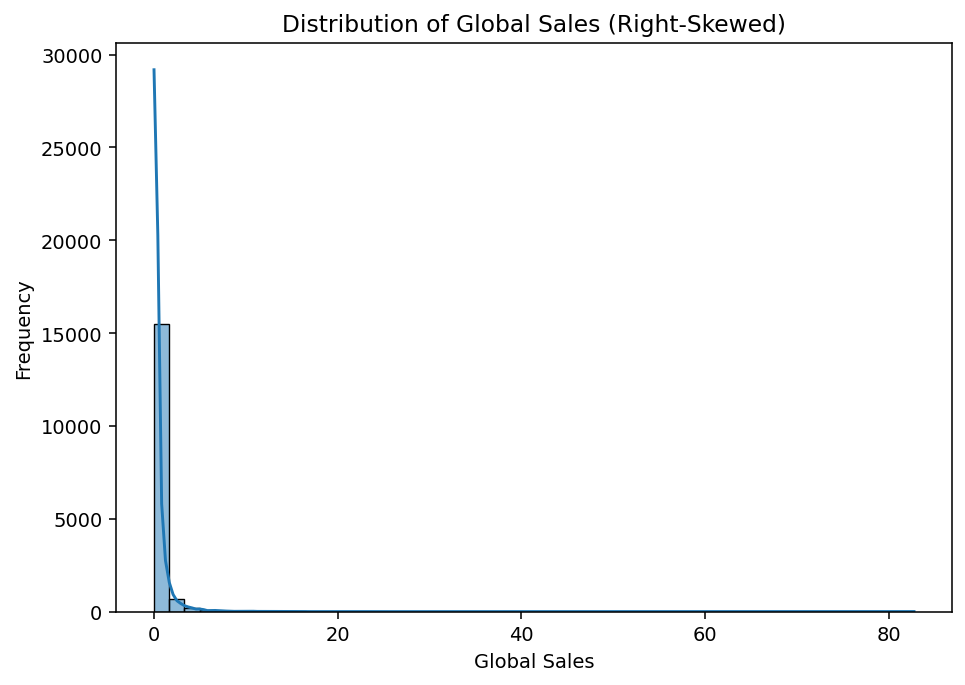

Skewness of Global_Sales: 17.400645097552452


In [6]:

# Distribution and skewness of Global Sales
plt.figure(figsize=(7,5), dpi=140)
sns.histplot(df["Global_Sales"], bins=50, kde=True)
plt.xlabel("Global Sales")
plt.ylabel("Frequency")
plt.title("Distribution of Global Sales (Right-Skewed)")
plt.tight_layout()
plt.show()

print("Skewness of Global_Sales:", df["Global_Sales"].skew())



## Exploratory Data Analysis (EDA)

Exploratory data analysis is performed to understand the distribution of the target variable,
identify outliers, examine skewness, and observe relationships between selected features and
global sales.



## 2) Data cleaning + missing values
We handle missing values using SimpleImputer inside pipelines.


In [7]:

# Missing values summary
df.isna().mean().sort_values(ascending=False)


,0
Year,0.016327
Publisher,0.003494
Rank,0.000000
Platform,0.000000
Name,0.000000
Genre,0.000000
NA_Sales,0.000000
EU_Sales,0.000000
JP_Sales,0.000000
Other_Sales,0.000000


In [8]:

# Basic cleaning: convert Year to numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Global_Sales"]).copy()
df.head()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37



## 3) EDA (Regression)
We explore target distribution and key relationships.


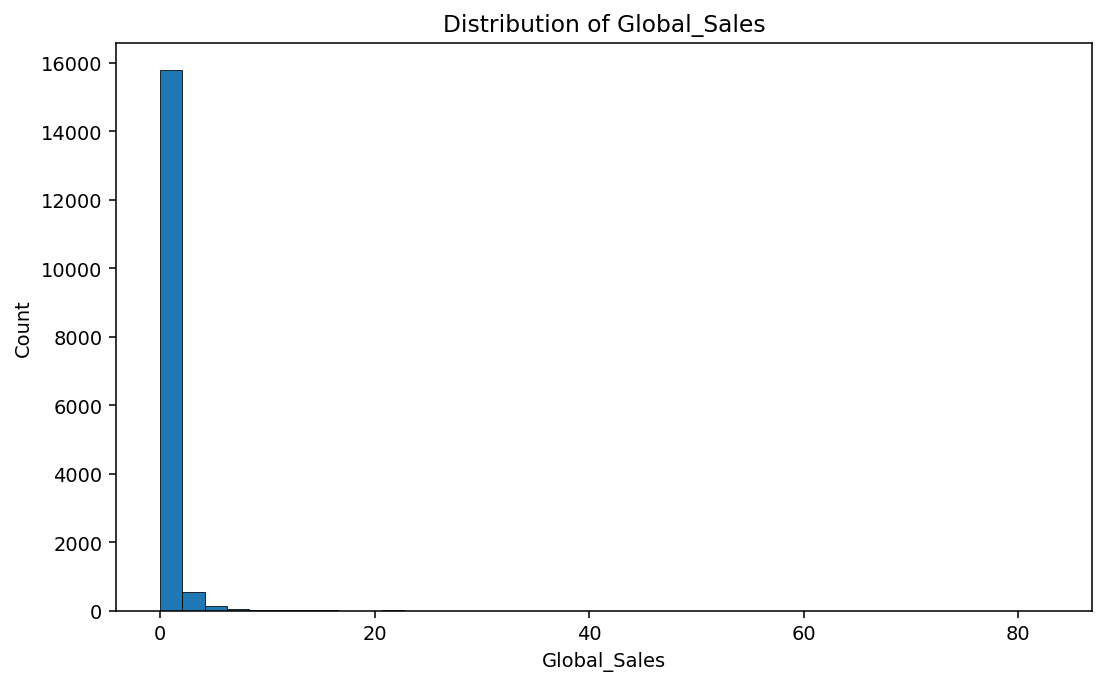

In [9]:

plt.figure(figsize=(8,5), dpi=140)
plt.hist(df["Global_Sales"], bins=40, edgecolor="black", linewidth=0.4)
plt.title("Distribution of Global_Sales")
plt.xlabel("Global_Sales")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


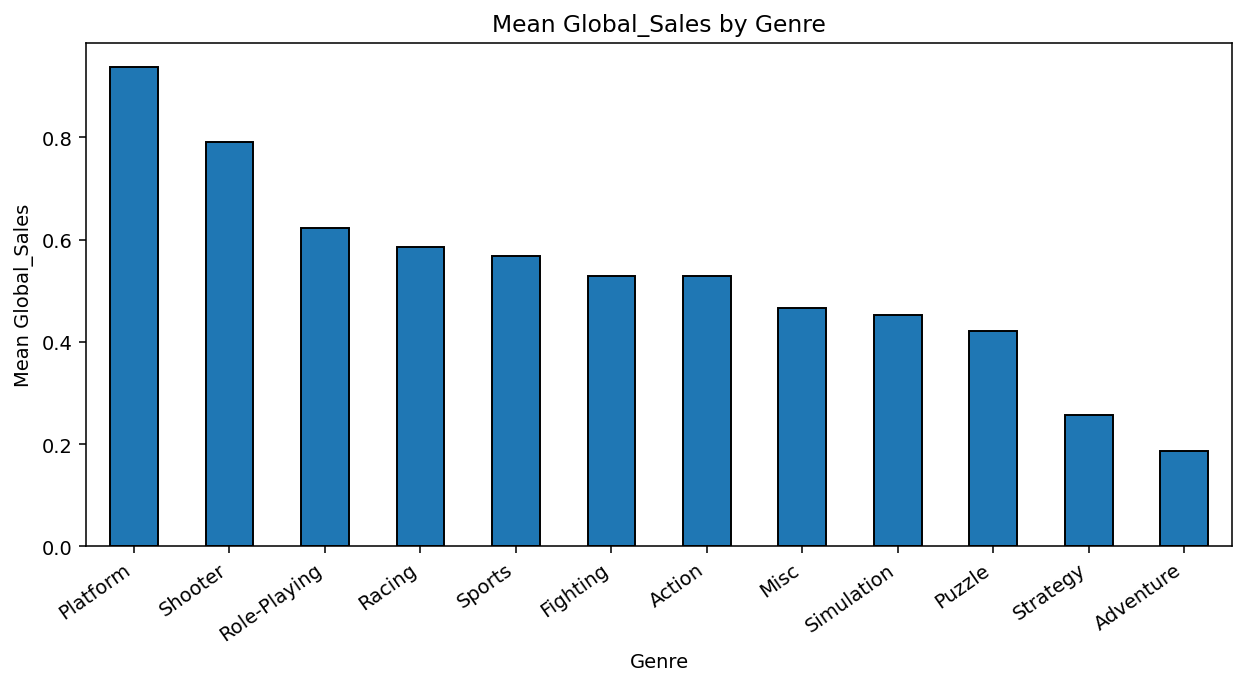

In [10]:

# Global sales by genre (mean)
genre_mean = df.groupby("Genre")["Global_Sales"].mean().sort_values(ascending=False)

plt.figure(figsize=(9,5), dpi=140)
genre_mean.plot(kind="bar", edgecolor="black")
plt.title("Mean Global_Sales by Genre")
plt.xlabel("Genre")
plt.ylabel("Mean Global_Sales")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()



## 4) Define features/target
To keep the modeling meaningful, we avoid target leakage by **not using regional sales** (NA/EU/JP/Other) to predict Global_Sales, since Global_Sales is derived from them.

We use: `Platform, Year, Genre, Publisher`.


In [11]:

features = ["Platform", "Year", "Genre", "Publisher"]
target = "Global_Sales"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_features = ["Year"]
categorical_features = ["Platform", "Genre", "Publisher"]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (13278, 4) Test shape: (3320, 4)



## 5) Build models
- Neural network regression (MLPRegressor)
- Two classical models: LinearRegression and RandomForestRegressor


In [26]:

def reg_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }


In [13]:

# Model A: Linear Regression
lin = LinearRegression()
lin_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", lin)])
lin_pipe.fit(X_train, y_train)

pred = lin_pipe.predict(X_test)
print("LinearRegression metrics:", reg_metrics(y_test, pred))


LinearRegression metrics: {'RMSE': np.float64(1.9558594715146447), 'MAE': 0.559041226487129, 'R2': 0.0894894387256312}


In [14]:

# Model B: Random Forest Regressor
rfr = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", rfr)])
rf_pipe.fit(X_train, y_train)

pred = rf_pipe.predict(X_test)
print("RandomForestRegressor metrics:", reg_metrics(y_test, pred))


RandomForestRegressor metrics: {'RMSE': np.float64(2.019144560431021), 'MAE': 0.5322962290268355, 'R2': 0.029614006600534704}


In [15]:

# Model C: Neural Network (MLPRegressor)
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)
mlp_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", mlp)])
mlp_pipe.fit(X_train, y_train)

pred = mlp_pipe.predict(X_test)
print("MLPRegressor metrics:", reg_metrics(y_test, pred))


MLPRegressor metrics: {'RMSE': np.float64(1.93662138424403), 'MAE': 0.5463129054680342, 'R2': 0.10731314712653783}


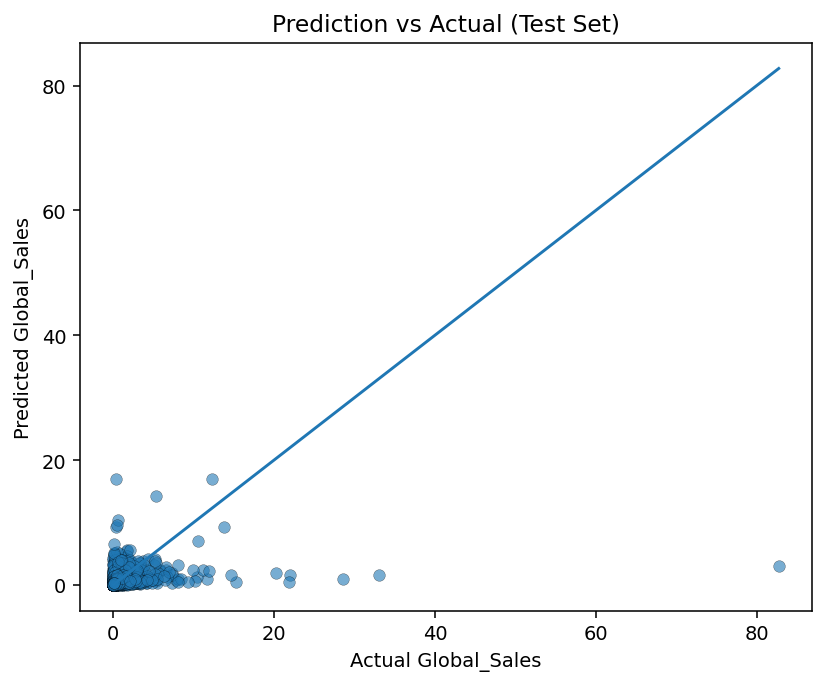

In [16]:

# Clean prediction vs actual plot (use best model here: RandomForest as an example)
best_pipe = rf_pipe
y_pred = best_pipe.predict(X_test)

plt.figure(figsize=(6,5), dpi=140)
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="black", linewidth=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title("Prediction vs Actual (Test Set)")
plt.xlabel("Actual Global_Sales")
plt.ylabel("Predicted Global_Sales")
plt.tight_layout()
plt.show()



## 6) Hyperparameter tuning with Cross-Validation
We tune two classical models:
- Ridge Regression (regularized linear model)  
- Random Forest Regressor


In [17]:

# Ridge Regression tuning (alpha)
ridge = Ridge()
ridge_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", ridge)])

ridge_grid = {"model__alpha": [0.1, 1.0, 10.0, 50.0]}

ridge_gs = GridSearchCV(
    ridge_pipe,
    ridge_grid,
    scoring="neg_root_mean_squared_error",  # higher is better (less negative)
    cv=5,
    n_jobs=-1
)
ridge_gs.fit(X_train, y_train)

print("Best Ridge CV score (neg RMSE):", ridge_gs.best_score_)
print("Best Ridge params:", ridge_gs.best_params_)


Best Ridge CV score (neg RMSE): -1.2917554822558581
Best Ridge params: {'model__alpha': 10.0}


In [18]:
# Random Forest tuning (ULTRA FAST)

rf_grid = {
    "model__n_estimators": [100],
    "model__max_depth": [None, 20]
}

rf_gs = GridSearchCV(
    rf_pipe,
    rf_grid,
    scoring="neg_root_mean_squared_error",
    cv=2,
    n_jobs=-1
)

rf_gs.fit(X_train, y_train)

print("Best RF CV score (neg RMSE):", rf_gs.best_score_)
print("Best RF params:", rf_gs.best_params_)


Best RF CV score (neg RMSE): -1.3778801167062165
Best RF params: {'model__max_depth': 20, 'model__n_estimators': 100}



## 7) Feature Selection
We apply SelectKBest (filter method) with f_regression.


In [19]:

k = 25

ridge_fs = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=f_regression, k=k)),
    ("model", Ridge(alpha=ridge_gs.best_params_["model__alpha"]))
])

rf_best_params = {k.replace("model__", ""): v for k,v in rf_gs.best_params_.items()}
rf_fs = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=f_regression, k=k)),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1, **rf_best_params))
])

ridge_fs.fit(X_train, y_train)
rf_fs.fit(X_train, y_train)

pred_ridge = ridge_fs.predict(X_test)
pred_rf = rf_fs.predict(X_test)

print("Ridge+FS:", reg_metrics(y_test, pred_ridge))
print("RF+FS:", reg_metrics(y_test, pred_rf))

# CV scores (neg RMSE)
ridge_fs_cv = GridSearchCV(ridge_fs, param_grid={}, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1).fit(X_train, y_train).best_score_
rf_fs_cv = GridSearchCV(rf_fs, param_grid={}, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1).fit(X_train, y_train).best_score_

print("Ridge+FS CV (neg RMSE):", ridge_fs_cv)
print("RF+FS CV (neg RMSE):", rf_fs_cv)


Ridge+FS: {'RMSE': np.float64(1.9671118164292103), 'MAE': 0.5606033483051233, 'R2': 0.07898270180178046}
RF+FS: {'RMSE': np.float64(1.9865201247952955), 'MAE': 0.5574796584110348, 'R2': 0.06071879790974899}
Ridge+FS CV (neg RMSE): -1.3070765461200973
RF+FS CV (neg RMSE): -1.4666780164997206



## 8) Final models + comparative table
Table format matches the PDF sample for regression comparison.


In [20]:

rows = []
rows.append({
    "Model": "Ridge Regression",
    "Features Used": f"Selected (k={k})",
    "CV Score (neg RMSE)": ridge_fs_cv,
    "Test RMSE": reg_metrics(y_test, pred_ridge)["RMSE"],
    "Test R2": reg_metrics(y_test, pred_ridge)["R2"]
})
rows.append({
    "Model": "Random Forest Regressor",
    "Features Used": f"Selected (k={k})",
    "CV Score (neg RMSE)": rf_fs_cv,
    "Test RMSE": reg_metrics(y_test, pred_rf)["RMSE"],
    "Test R2": reg_metrics(y_test, pred_rf)["R2"]
})

comparison = pd.DataFrame(rows)
comparison


,Model,Features Used,CV Score (neg RMSE),Test RMSE,Test R2
0,Ridge Regression,Selected (k=25),-1.307077,1.967112,0.078983
1,Random Forest Regressor,Selected (k=25),-1.466678,1.986520,0.060719
